# Analyse quality of FEI Face Database
https://fei.edu.br/~cet/facedatabase.html

In [1]:
import os
from tqdm import tqdm
images_base_addr = '/home/tmd4/FEI_face_db/'
jpeg_files = [f for f in os.listdir(images_base_addr) if '.jpg' in f]
jpeg_files.sort(key=lambda x: int(x.split('-')[0])*100 + int(x.split('-')[1].split('.')[0]))

In [5]:
!nvidia-smi

Sun May  7 11:21:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:E3:00.0 Off |                    0 |
| N/A   29C    P0    36W / 250W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## All angles of 1 person vs same angle for multiple people

In [2]:
jpeg_files_dict = {}
for j in jpeg_files:
    name, pose = j.split('-')
    name = int(name)
    pose = pose.split('.')[0]
    pose = int(pose)
    if pose > 11:
        continue
    if name not in jpeg_files_dict:
        jpeg_files_dict[name] = {}
    jpeg_files_dict[name][pose] = images_base_addr + j

In [3]:
import numpy as np
l_r_center, square_height = int(640/2), 400
top_crop = 1
left, upper, right, lower = l_r_center - int(square_height/2), top_crop, l_r_center + int(square_height/2), square_height + top_crop
def crop_img(img: np.ndarray):
    return img[upper:lower, left:right, :]

In [4]:
# Same person multiple angles
# https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30
import imageio

with imageio.get_writer('person1_angles1to11.gif', mode='I') as writer:
    for filename in jpeg_files_dict[1].values():
        image = imageio.v2.imread(filename)
        writer.append_data(crop_img(image))

<img src="./person1_angles1to11.gif" width="350px" align="center">

In [5]:
# Same angle multiple people
max_angles = 2 # all 11 angles (12) takes a while + lots of space
for angle in tqdm(range(1,max_angles)):
    with imageio.get_writer(f'all_persons_angle_{angle}.gif', mode='I') as writer:
        for i in range(1,201):
            filename = jpeg_files_dict[i][angle]
            image = imageio.v2.imread(filename)
            writer.append_data(crop_img(image))

100%|██████████| 1/1 [00:13<00:00, 13.19s/it]


## Amazon Rekognition API angle analysis

Investigating how accurate following is
<img src="https://miro.medium.com/v2/resize:fit:1382/format:webp/1*U4ZQ8UjzouVMRo2Fgsz7UA.png" width="350px" align="center">

<img src="all_persons_angle_1.gif" width="350px" align="center">

In [5]:
import json
import pandas as pd
pose_dict = {'pitch': [], 'roll': [], 'yaw': [], 'person_idx': [],
            'pose_idx': [], 'image_addr': []}
pitch, roll, yaw = {}, {}, {}
for f in jpeg_files:
    json_file = open(images_base_addr + f.replace('.jpg', '.json'), 'r')
    faceDetail = json.load(json_file)
    json_file.close()
    if len(faceDetail['FaceDetails']) == 0:
        # print(f)
        continue

    pose = faceDetail['FaceDetails'][0]['Pose']
    p, r, y = pose['Pitch'], pose['Roll'], pose['Yaw']
    pose_idx = (f.split('-')[1].split('.')[0])
    if pose_idx == '10' and abs(r) > 10:
        r = 0
    if pose_idx == '10' and abs(p) > 10:
        p = 0
    pose_dict['pitch'].append(p)
    pose_dict['roll'].append(r)
    pose_dict['yaw'].append(y)
    pose_dict['person_idx'].append(f.split('-')[0])
    pose_dict['pose_idx'].append(pose_idx)
    pose_dict['image_addr'].append(f)
    
pose_df = pd.DataFrame(pose_dict)
pose_df_filt = pose_df[pose_df['pose_idx'].map(lambda x: int(x)) <= 11]

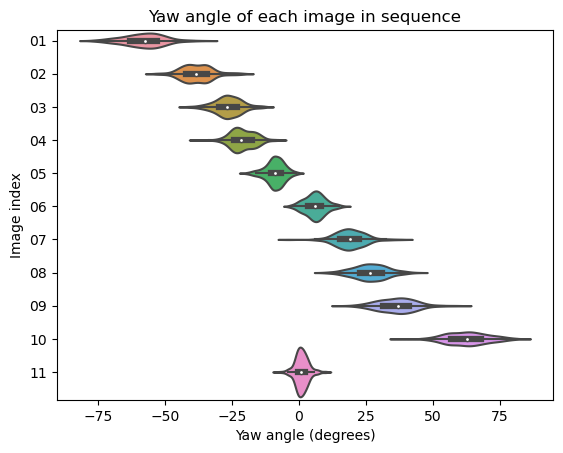

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def violin_plot(pose_type):
    sns.violinplot(data=pose_df_filt, orient='h', x=pose_type.lower(), y='pose_idx', showmeans=True, width=1.5)
    plt.title(f'{pose_type.capitalize()} angle of each image in sequence')
    plt.xlabel(f'{pose_type.capitalize()} angle (degrees)')
    plt.ylabel('Image index')
    plt.margins(y=.008)
    plt.show()
    
violin_plot('yaw')

In [6]:
from tqdm.contrib.concurrent import process_map
from PIL import Image
import io

def process_image(img_filename):
    cropped_img = crop_img(imageio.v2.imread(images_base_addr + img_filename))
    out = Image.fromarray(cropped_img).resize((128, 128))
    img_byte_arr = io.BytesIO()
    out.save(img_byte_arr, format='PNG')
    return img_byte_arr.getvalue()
    # return imageio.v3.imwrite("<bytes>", cropped_img, extension=".png")
cropped_image_data = process_map(process_image, pose_df_filt['image_addr'], chunksize=10)
image_data = {}
for name, data in zip(pose_df_filt['image_addr'], cropped_image_data):
    image_data[name] = data

  0%|          | 0/2200 [00:00<?, ?it/s]

In [10]:
# To quickly make a scatter (no colours with plotly)
# import plotly.express as px
# fig = px.violin(data_frame=pose_df_filt, x='yaw', y='pose_idx', hover_data='image_addr')
# fig.show()

from ipywidgets import HBox, VBox
from ipywidgets import Image, Layout
import plotly.graph_objects as go


def interactive_violin_plot(pose_type):
    fig = go.FigureWidget()
    for pose_idx in pose_df_filt['pose_idx'].unique():
        pose_filter = pose_df_filt['pose_idx'] == pose_idx
        fig.add_trace(go.Violin(x=pose_df_filt[pose_filter][pose_type.lower()], line_color='black',
                                meanline_visible=True, fillcolor='lightseagreen', customdata=pose_df_filt[pose_filter]['image_addr'],
                                opacity=0.6, name=pose_idx))
    fig.update_layout({'xaxis_title': f'{pose_type.capitalize()} angle (degrees)',
                       'yaxis_title':'Image index', 
                       'title': f'Analyse {pose_type.capitalize()} angle outliers using image'})

    

    image_widget = Image(
        value=image_data['1-01.jpg'],
        layout=Layout(height='240px', width='320px')
    )

    def hover_fn(trace, points, state):
        if len(points.point_inds) < 1: return
        ind = points.point_inds[0]
        image_widget.value = image_data[trace['customdata'][ind]]

    for vplot in fig.data:
        vplot.on_hover(hover_fn)

    return VBox([fig, image_widget])
interactive_violin_plot('yaw')

    'data': [{'customdata': array(['1-01.jpg', '2-01.jpg', '3-01.jpg', '4-01.jpg…

## Roll and pitch quick analysis

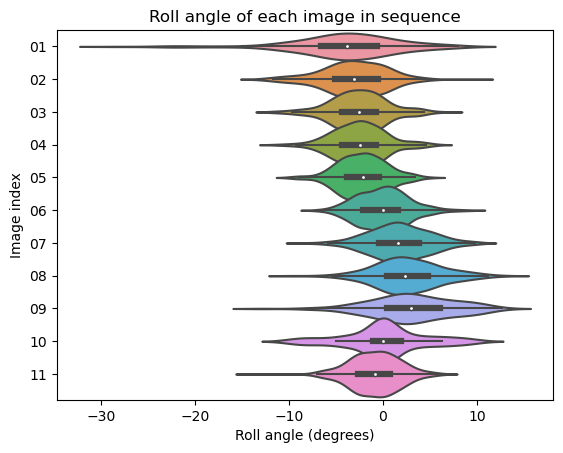

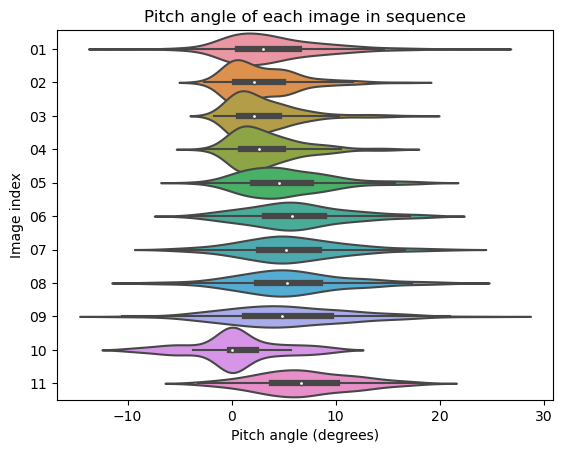

In [11]:
violin_plot('roll')
violin_plot('pitch')

In [12]:
interactive_violin_plot('roll')

    'data': [{'customdata': array(['1-01.jpg', '2-01.jpg', '3-01.jpg', '4-01.jpg…

In [12]:
from sklearn.model_selection import ShuffleSplit
from scipy.spatial.transform import Rotation as R

splitter = ShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=12)
train_idxs, test_idxs = next(splitter.split(pose_df_filt['person_idx'].unique()))
train_people = pose_df_filt['person_idx'].unique()[train_idxs]
test_people = pose_df_filt['person_idx'].unique()[test_idxs]

def convert_pose_to_xy(yaw, pitch, roll):
    # construct the camera at x = 1 and rotate it so correctly points at origin
    cam_point = np.array([1,0,0])
    init_cam_rot = R.from_euler('zy', [90,-90], degrees=True)
    rotated_cam_point = init_cam_rot.apply(cam_point) # gives same point as rotate camera using euler angle

    obj_point = np.array([0,0,0])
    obj_rotation = R.from_euler('yzx', [-pitch, yaw, -roll], degrees=True)
    obj_rotation.apply(obj_point) # gives same point as rotate object using euler angle

    inv_obj_rotation = R.from_matrix(obj_rotation.inv().as_matrix())
    new_cam_point = inv_obj_rotation.apply(cam_point)
    camera_rot = inv_obj_rotation * init_cam_rot
    camera_rot_quat = camera_rot.as_quat()
    # quaternions normally written as w,x,y,z so need to roll x,y,z,w over by 1
    combined_pose = np.append(new_cam_point, np.roll(camera_rot_quat, 1)) # np
    return combined_pose.tolist()

In [15]:
test_person = test_people[0]
test_person_df = pose_df_filt[pose_df_filt['person_idx'] == test_person]
print(test_person_df)
seven_d_poses = [convert_pose_to_xy(row['yaw'], row['pitch'], row['roll']) for _, row in test_person_df.iterrows()]

         pitch      roll        yaw person_idx pose_idx image_addr
322  -0.298857  6.793706 -59.170528         24       01  24-01.jpg
323  -0.406532  2.139383 -42.053719         24       02  24-02.jpg
324  -0.108907  0.817322 -29.651442         24       03  24-03.jpg
325   0.142935  0.485463 -22.648348         24       04  24-04.jpg
326   3.711559 -0.983740  -9.430623         24       05  24-05.jpg
327   6.001660 -0.776872   8.942954         24       06  24-06.jpg
328   5.151376 -2.797753  22.924946         24       07  24-07.jpg
329   2.172636 -1.677125  33.528210         24       08  24-08.jpg
330  -4.060289 -7.066309  46.636436         24       09  24-09.jpg
331  -3.728201 -8.561275  63.541386         24       10  24-10.jpg
332  13.533795 -1.242843  -0.410953         24       11  24-11.jpg


11it [00:03,  3.08it/s]


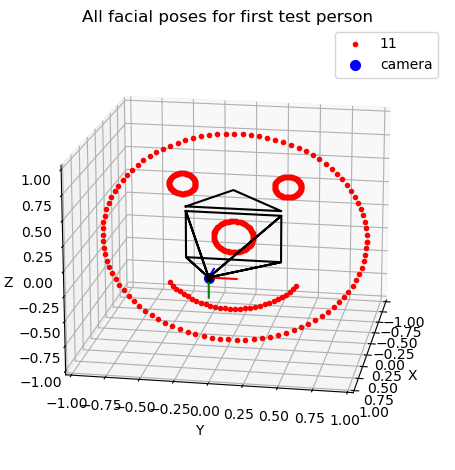

In [49]:
# First we want to keep camera steady and rotate face
import matplotlib.pyplot as plt
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
from mpl_toolkits.mplot3d import Axes3D

# make default face
def add_circle(dy, dz, radius):
    s = np.linspace(0,2*np.pi,100)
    return np.stack((np.zeros_like(s), dy+ radius*np.cos(s), dz+radius*np.sin(s)))

P = add_circle(0, 0, 1)
nose_dist = 0.4
P = np.hstack((P, add_circle(-nose_dist, .5, .1), add_circle(nose_dist, .5, .1)))
P = np.hstack((P, add_circle(0, 0, .15)))
P = np.hstack((P, add_circle(0, -0.1, .6)[:,60:90]))

# default parameters of a camera in Blender
sensor_size = np.array([0.036, 0.024])
intrinsic_matrix = np.array([
    [0.05, 0, sensor_size[0] / 2.0],
    [0, 0.05, sensor_size[1] / 2.0],
    [0, 0, 1]
])
virtual_image_distance = 1
basic_camera_pose = convert_pose_to_xy(0, 0, 0)
basic_camera_transform = pt.transform_from_pq(basic_camera_pose)

# make figure
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# make and plot other faces - https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
colors = plt.cm.rainbow(np.linspace(0, 1, len(seven_d_poses)))
frames = []
for (_, row), color in tqdm(zip(test_person_df.iterrows(), colors)):
    ax.cla()
    ax.set_xlabel('X')
    ax.set_xlim(-1,1)
    ax.set_ylabel('Y')
    ax.set_ylim(-1,1)
    ax.set_zlabel('Z')
    ax.set_zlim(-1,1)
    ax.set_title('All facial poses for first test person', pad=1)
    obj_rotation = R.from_euler('yzx', [-row['pitch'], row['yaw'], -row['roll']], degrees=True)
    Pr = np.zeros_like(P.T)
    for i, (x,y,z) in enumerate(P.T):
        Pr[i][:] = obj_rotation.apply([x,y,z])
    pose_index = row['pose_idx']
    ax.plot(Pr[:,0],Pr[:,1],Pr[:,2], 'o', zdir='z',label=pose_index, c=color, markersize=3)
    plt.plot(basic_camera_pose[0],basic_camera_pose[1],basic_camera_pose[2],'o',label='camera',markersize=7, c='blue')
    pt.plot_transform(ax=ax, A2B=basic_camera_transform, s=0.2)
    pc.plot_camera(
        ax, cam2world=basic_camera_transform, M=intrinsic_matrix, sensor_size=sensor_size,
        virtual_image_distance=virtual_image_distance)
    ax.view_init(elev=17, azim=10)
    ax.margins(y=0)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'camera_still_gif/{pose_index}.png')

    image = imageio.v2.imread(f'camera_still_gif/{pose_index}.png')
    frames.append(image)
    
imageio.mimsave('camera_still.gif', # output gif
                frames,          # array of input frames
                duration = 10)

# plt.show()

<img src="./camera_still.gif" width="350px" align="center">

In [ ]:


# https://machinelearning1.wordpress.com/2019/05/27/quaternions-use-them-for-rotation-and-transformation/


P = add_circle(0, 0, 1)
nose_dist = 0.4
P = np.hstack((P, add_circle(-nose_dist, .5, .1), add_circle(nose_dist, .5, .1)))
P = np.hstack((P, add_circle(0, 0, .15)))
P = np.hstack((P, add_circle(0, -0.1, .6)[:,60:90]))

P = P.T
Pr = np.zeros_like(P)
for i, (x,y,z) in enumerate(P):
    Pr[i][:] = obj_rotation.apply([x,y,z])

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
for idx, f in enumerate([P, Pr]):
    ax.plot(f[:,0],f[:,1],f[:,2], 'o', zdir='z',label=f'{idx}', c=['red', 'blue'][idx], markersize=3)
plt.plot(cam_point[0],cam_point[1],cam_point[2],'o',label='cam',markersize=7, c='blue')
plt.plot(new_cam_point[0], new_cam_point[1],new_cam_point[2],'o',label='new cam',markersize=7, c='red')
# scipy makes x, y, z, w, BUT w,x,y,z is how to visualise
cam2world = pt.transform_from_pq(np.append(new_cam_point, np.roll(camera_rot_quat, 1)))
pt.plot_transform(ax=ax, A2B=cam2world, s=0.2)
pt.plot_transform(ax=ax, A2B=pt.transform_from(np.eye(3), np.zeros((3))), s=0.2)
pc.plot_camera(
    ax, cam2world=cam2world, M=intrinsic_matrix, sensor_size=sensor_size,
    virtual_image_distance=virtual_image_distance)
ax.view_init(elev=9, azim=88)
plt.show()

## Generate tf dataset from images and poses

In [34]:
from scipy.spatial.transform import Rotation as R
import tensorflow as tf
from viewformer.data.tfrecord_dataset import build_shard_index
# features = ["cameras","frames"]
# sequence_size = 20 # 11 in reality
# poses_num_dim = 7 # xyz + quaternion
# feature_description = {"cameras": tf.io.FixedLenFeature([sequence_size * poses_num_dim], tf.float32),
#                         "frames": tf.io.FixedLenFeature([sequence_size], tf.string)}



def save_train_test_data(name, people):
    print(f'{name} dataset contains {len(people)} people')
    dataset_name = 'feitrue'
    example_path = f'/scratch/network/tmd4/viewformer/datasets/{dataset_name}/{dataset_name}-{name}-000001-of-000001.tfrecord'
    with tf.io.TFRecordWriter(example_path) as file_writer:
      for person_idx, person_df in tqdm(pose_df_filt.groupby('person_idx')):
        if person_idx not in people: continue
        person_df['pose_idx'] = person_df['pose_idx'].astype(int)
        person_df = person_df.sort_values(by='pose_idx')

        # pose creation
        pose = []
        for i, row in person_df.iterrows():
            # temp until do proper transformation to x,y,z + quaternion
            pose.append(convert_pose_to_xy(row['yaw'], row['pitch'], row['roll']))
#         while len(pose) < 20:
#             pose.append(pose[-1]) # padding
        pose = np.array(pose)

        # frames creation
        png_images = [] # precropped computed png strings
        for i, row in person_df.iterrows():
            png_images.append(image_data[row['image_addr']])
#         while len(png_images) < 20:
#             png_images.append(png_images[-1]) # padding


        record_bytes = tf.train.Example(features=tf.train.Features(feature={
            "cameras": tf.train.Feature(float_list=tf.train.FloatList(value=pose.reshape(-1))),
            "frames": tf.train.Feature(bytes_list=tf.train.BytesList(value=png_images)),
        })).SerializeToString()
        file_writer.write(record_bytes)
    build_shard_index(example_path, 
                  f'/scratch/network/tmd4/viewformer/datasets/{dataset_name}/{dataset_name}-{name}-000001-of-000001.index')

    
save_train_test_data('train', train_people)
save_train_test_data('test', test_people)
# 11 images per person


train dataset contains 160 people


100%|██████████| 200/200 [00:00<00:00, 445.10it/s]


test dataset contains 40 people


100%|██████████| 200/200 [00:00<00:00, 1615.90it/s]


In [31]:
for person_idx, person_df in tqdm(pose_df_filt.groupby('person_idx')):
    print(person_df)
    print(len(person_df))
    break




  0%|          | 0/200 [00:00<?, ?it/s]

        pitch      roll        yaw person_idx pose_idx image_addr
0   -4.737607  6.096374 -73.048820          1       01   1-01.jpg
1    1.924812 -0.147746 -44.781761          1       02   1-02.jpg
2    3.135089 -0.174962 -30.699774          1       03   1-03.jpg
3    4.653462  0.187032 -24.133297          1       04   1-04.jpg
4   10.316760 -0.177117  -6.932323          1       05   1-05.jpg
5   10.353795  1.412049  11.723193          1       06   1-06.jpg
6    4.664229  2.566674  32.536915          1       07   1-07.jpg
7    4.772633  1.378026  38.282116          1       08   1-08.jpg
8   -1.756281 -3.778361  50.697029          1       09   1-09.jpg
9    0.000000  0.000000  75.757988          1       10   1-10.jpg
10  12.177956  0.563310   2.787667          1       11   1-11.jpg
11


In [35]:
160*11


1760